In [ ]:
# Let's start by creating a sample dataset.

from zbench.common_types import QueryDocuments, Query, Document
from zbench.utils import save_pydantic_jsonl
from dotenv import load_dotenv

# Load api keys from .env file
load_dotenv(override=True) 

dataset: list[QueryDocuments] = [
    QueryDocuments(
        query=Query(id="Q1", query="What is the capital of France?"),
        documents=[
            Document(id="d1", content="Paris is the capital of France."),
            Document(id="d2", content="Rome is the capital of Italy."),
        ]
    )
]

save_pydantic_jsonl("my_sample_dataset.jsonl", dataset)

/Users/alpha_kotenok/Documents/Projects/ZeroEntropy/zbench/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# At first, we need to annotate the dataset.
# We can do this by running the following code:

from zbench.annotation import DatasetAnnotator

annotator = DatasetAnnotator("my_sample_dataset.jsonl")
await annotator.annotate()

# Now, we have an annotated dataset called "my_samle_dataset_annotated.jsonl" in the working directory.

Step 1: Loading dataset
Loaded 1 queries from data/annotation/my_samle_dataset/dataset.jsonl
Step 2: Creating pairs for AI scoring


Creating pairs: 100%|██████████| 1/1 [00:00<00:00, 1351.26it/s]


Created 8 pairs and saved to data/annotation/my_samle_dataset/pairs.json
Step 3: Scoring pairs


Scoring Pairs: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]

Scored 8 pairs and saved to data/annotation/my_samle_dataset/sai_scores.json
Step 4: Composing annotated dataset
Created 1 annotated lines
Saved annotated dataset to my_samle_dataset_annotated.jsonl

🎉 Annotation completed successfully!
Final outputs:
Annotated dataset: my_samle_dataset_annotated.jsonl


In [ ]:
# Having an annotated dataset, we can define a reranker based on it.
# We also can define any other reranker by inheriting from the BaseReranker class.

from zbench.rerankers import EnsembleReranker, BaseReranker, RerankerInput

ensemble_reranker = EnsembleReranker("my_sample_dataset_annotated.jsonl")

class MyReranker(BaseReranker):
    def __init__(self):
        self.my_variable = 1

    async def score(self, input: RerankerInput) -> list[float]:
        return [0.5] * len(input.documents)
    
my_reranker = MyReranker()

Calculating NDCG Scores: 100%|██████████| 1/1 [00:00<00:00, 1531.33it/s]


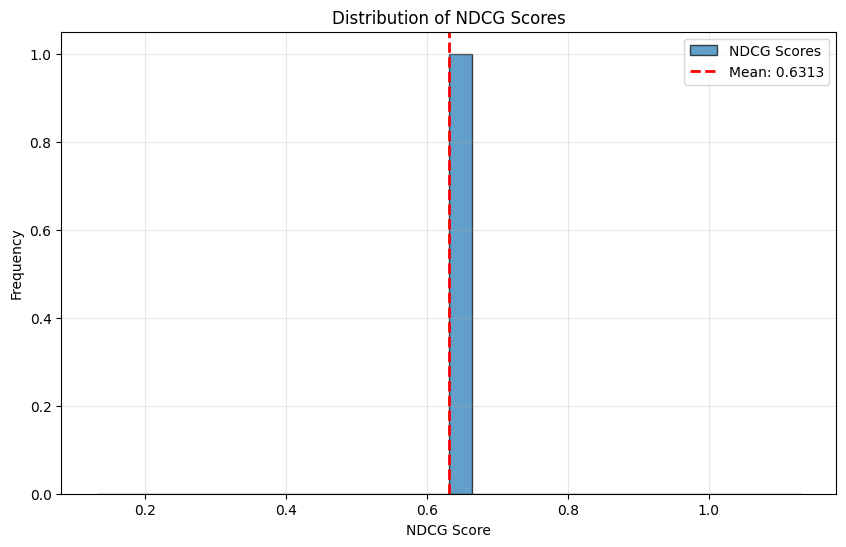

[np.float64(0.6312531502538729)]


Calculating Accuracy Scores: 100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


[0.0]


Calculating Recall Scores: 100%|██████████| 1/1 [00:00<00:00, 4148.67it/s]

[0.0]


In [ ]:
# Finally, we can run three benchmarks:

from zbench.benchmark import benchmark_ndcg, benchmark_accuracy, recall_at_k

print(await benchmark_ndcg("my_sample_dataset.jsonl", my_reranker, ensemble_reranker, visualize=True)) # you can visualise the ndcg score distribution
print(await benchmark_accuracy("my_sample_dataset.jsonl", my_reranker, ensemble_reranker))
print(await recall_at_k("my_sample_dataset.jsonl", my_reranker, ensemble_reranker, 1, k_gt=1))

# As for recall at k, we also introduce a parameter k_gt, which is the number of ground truth documents to consider since the annotation does not separate the ground truth, just the order. For the best results, you can tune k_gt depending on the annotations score distritribution.

Calculating NDCG Scores: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


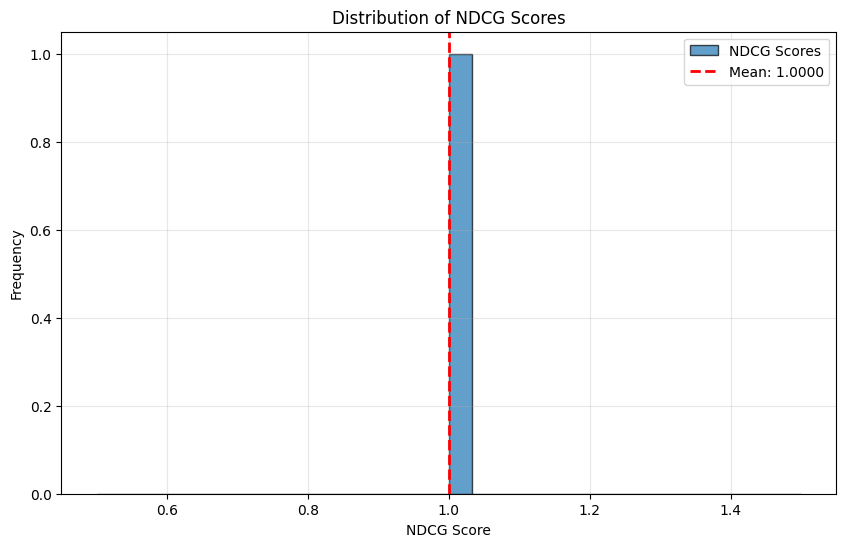

[np.float64(1.0)]


Calculating Accuracy Scores: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


[1.0]


Calculating Recall Scores: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

[1.0]


In [ ]:
# You can also use built-in zerank reranker.

from zbench.rerankers import Zerank

zerank = Zerank("zerank-1")

# Now, you can run the benchmarks:

print(await benchmark_ndcg("my_sample_dataset.jsonl", zerank, ensemble_reranker, visualize=True))
print(await benchmark_accuracy("my_sample_dataset.jsonl", zerank, ensemble_reranker))
print(await recall_at_k("my_sample_dataset.jsonl", zerank, ensemble_reranker, 1, k_gt=1))